In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('taxonomy_working.pkl')

In [3]:
df.head()

,Responsable,T1,T2,item_name,item_description,item_code,frn_id,category,_merge,item_text,tokens,n_tokens,prep_text
0,Ana,Pollo,Alitas,Alitas 10 piezas,Salsa a elegir.,72365267,266868,Snacks,both,Snacks Alitas 10 piezas Salsa a elegir,"[snacks, alitas, piezas, salsa, elegir]",5,snacks alitas piezas salsa elegir
1,Rodo,Saludable,Ensalada,Ensalada Philadelphia,"A elegir 1 Cama de lechugas Frescas, Más 3 Sem...",69394214,252803,Ensaladas,both,Ensaladas Ensalada Philadelphia A elegir 1 Cam...,"[ensaladas, ensalada, philadelphia, elegir, ca...",23,ensaladas ensalada philadelphia elegir cama le...
2,Jose,Tacos,Tacos Otros,Hamburguesa Valdéz,"200 grs. De molida de sirloin, pan artesanal, ...",65,207665,Hamburguesas al Carbón,both,Hamburguesas al Carbón Hamburguesa Valdéz 200 ...,"[hamburguesas, carbón, hamburguesa, valdéz, gr...",22,hamburguesas carbón hamburguesa valdéz grs mol...
3,Alfredo,Hamburguesas,Hamburguesa,LA BBQ DE LUXE!,"pan artesanal,jitomate, cebolla lechuga, pepin...",33141492,48028,HAMBURGUESAS AL CARBON,both,HAMBURGUESAS AL CARBON LA BBQ DE LUXE pan art...,"[hamburguesas, carbon, bbq, luxe, pan, artesan...",16,hamburguesas carbon bbq luxe pan artesanal jit...
4,Ana,Pizza,Pizza gourmet,2 Pizza Grande 4 Ingredientes.,"Base de salsa pomodora, queso mozzarella y que...",539849,539157,Pizzas,both,Pizzas 2 Pizza Grande 4 Ingredientes Base de ...,"[pizzas, pizza, grande, ingredientes, base, sa...",11,pizzas pizza grande ingredientes base salsa po...


# embedding

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

docs = df.prep_text

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

Using TensorFlow backend.


In [11]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 40
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs.shape)


(6681, 40)


In [13]:
# del embeddings_index
embeddings_index = {}
f = open('embeddings/ES-SBW-vectors-300-min5.txt')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

1000654it [00:55, 18053.52it/s]

Found 1000654 word vectors.


In [14]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
        
del embeddings_index

In [15]:
vocab_size = embedding_matrix.shape[0]
embedding_size = embedding_matrix.shape[1]


## BiLSTM

In [16]:
# This code is inspirated by https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
#         return input_shape[0],  self.features_dim
 

## train test split

In [17]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Naive class imbalance correction
imbal = df.T2.value_counts().index[df.T2.value_counts() < 10]

df['T2_isimbal'] = df.T2.map(lambda x: x in list(imbal))
df['T2_corrected'] = df.T2

df.loc[df.T2_isimbal,['T2_corrected']] = 'Otros otros' 

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df.T2_corrected.map(str))
print(integer_encoded)


[ 0 23 57 ... 42 43 28]


In [18]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [78]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

docs = df.prep_text

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(df.prep_text)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 40
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs.shape)


(6681, 40)


In [79]:
n_classes = y.shape[1]

In [19]:
print('\nPreparing the data for LSTM...')
X = padded_docs
print('X shape:', X.shape)



Preparing the data for LSTM...
X shape: (6681, 40)


In [20]:
from sklearn.model_selection import train_test_split

# X = padded_docs
# le.inverse_transform([0, 0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [22]:
n_classes = y.shape[1]

In [45]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, GlobalMaxPooling1D, Conv1D
from keras.layers import LSTM, Bidirectional, Dropout, GRU


def BidLstm(maxlen, max_features, embed_size, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.2,
                           recurrent_dropout=0.2))(x)    
    x = Attention(n_classes)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model


In [46]:
vocab_size, embedding_size = embedding_matrix.shape

model = BidLstm(maxlen=max_length,
                max_features= vocab_size,
                embed_size= embedding_size,
                embedding_matrix=embedding_matrix,
                n_classes=n_classes)

In [47]:
# Load TENSORBOARD
%load_ext tensorboard
# Start TENSORBOARD
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7587), started 4:28:29 ago. (Use '!kill 7587' to kill it.)

In [48]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 40, 300)           1724100   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 40, 600)           1442400   
_________________________________________________________________
attention_5 (Attention)      (None, 600)               640       
_________________________________________________________________
dense_7 (Dense)              (None, 256)               153856    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1644

In [49]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
np.random.seed(7)

model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
file_path = ".model.hdf5"
ckpt = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                           save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=15)
tensorBoard = TensorBoard(log_dir = "./logs", histogram_freq = 1)


In [50]:
model.fit(X_train, y_train, batch_size=500, epochs=100, validation_split=0.1, callbacks=[tensorBoard,ckpt, early])
#model.fit(xtr, y, batch_size=256, epochs=1, validation_split=0.1)

Train on 4809 samples, validate on 535 samples
Epoch 1/100
4809/4809 [==============================] - 14s 3ms/step - loss: 3.9692 - accuracy: 0.0867 - val_loss: 3.6965 - val_accuracy: 0.0748

Epoch 00001: val_loss improved from inf to 3.69654, saving model to .model.hdf5
Epoch 2/100
4809/4809 [==============================] - 14s 3ms/step - loss: 3.6595 - accuracy: 0.1004 - val_loss: 3.6342 - val_accuracy: 0.0860

Epoch 00002: val_loss improved from 3.69654 to 3.63418, saving model to .model.hdf5
Epoch 3/100
4809/4809 [==============================] - 14s 3ms/step - loss: 3.5777 - accuracy: 0.1370 - val_loss: 3.5736 - val_accuracy: 0.1308

Epoch 00003: val_loss improved from 3.63418 to 3.57361, saving model to .model.hdf5
Epoch 4/100
4809/4809 [==============================] - 16s 3ms/step - loss: 3.4505 - accuracy: 0.1859 - val_loss: 3.4264 - val_accuracy: 0.1757

Epoch 00004: val_loss improved from 3.57361 to 3.42636, saving model to .model.hdf5
Epoch 5/100
4809/4809 [==========

In [35]:
model.save('bilstm_attention_V1.h5')

# Model evaluation

In [36]:
from keras.models import load_model

model = load_model('bilstm_attention_V1.h5', custom_objects={'Attention' : Attention})
#model = Model(inputs=model.input,
              #outputs=[model.output, model.get_layer('attention_7').output])

In [51]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 72.924459


In [130]:
from sklearn.metrics import confusion_matrix

In [131]:
y_pred = model.predict(X_test)
y_pred_decoded = np.argmax(y_pred,axis=1)

In [132]:
y_test_decoded = np.argmax(y_test,axis=1)

In [133]:
confusion_matrix(y_test_decoded, y_pred_decoded)

array([[26,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 13, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  8,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  4]])

In [134]:
import seaborn as sn
import matplotlib.pyplot as plt 

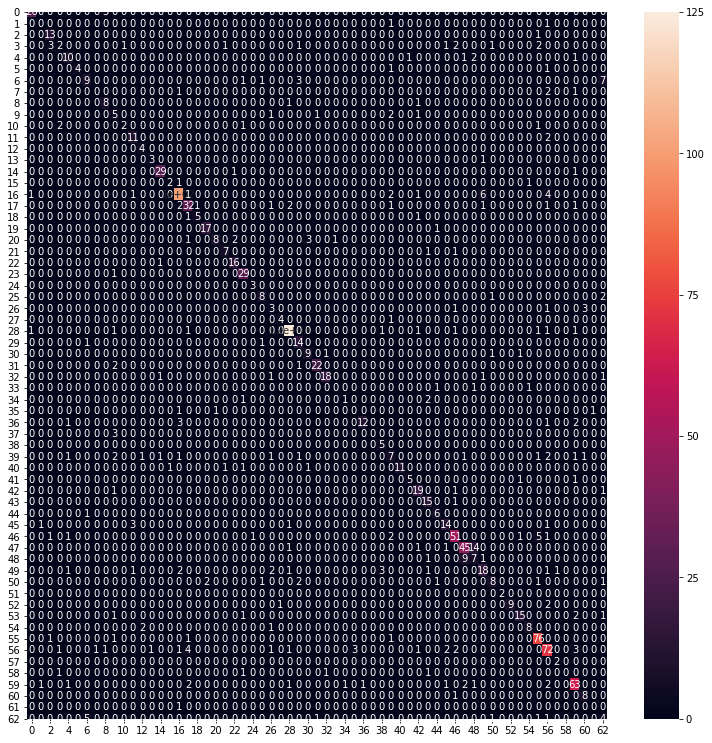

In [135]:
from sklearn import metrics
plt.figure(figsize = (13,13))
sn.heatmap(metrics.confusion_matrix(y_test_decoded, y_pred_decoded), annot=True)


In [136]:
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.metrics import *

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


In [137]:
multiclass_roc_auc_score(y_test_decoded,y_pred_decoded)

0.8239303465507467

In [138]:
y_pred_decoded[:15]

array([28, 60, 60, 23, 28, 28, 57, 28, 56, 23, 16, 54, 60, 60, 60])

In [139]:
y_test_decoded[:15]

array([28, 54, 60, 23, 28, 28, 57, 28, 56, 23, 16, 54, 60, 60, 60])

In [140]:
accuracy_score(y_test_decoded, y_pred_decoded)

0.7718773373223635

## Visualizing attention

In [300]:
outputs = model.predict(X_test)
model_outputs = outputs[0]
attention_outputs = outputs[1]

In [301]:
np.argmax(model_outputs,axis=1)

array([57, 56, 46, ...,  0, 22, 49])

In [197]:
import random
i = random.randint(0,len(df))

In [198]:
df.prep_text[i]

'bagel bagel atún atún mayonesa lechuga tomate pepino cebolla aguacate'

In [199]:
np.array(padded_docs[i])

array([662, 662, 213, 213,  38,  13,  42,  44,   4,  17,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [191]:
outputs = model.predict(np.array(padded_docs[i:i+1]))


In [192]:
pred_class = np.argmax(outputs,axis=1)
print(pred_class)

[26]


In [193]:
label_encoder.inverse_transform(pred_class)

array(['Garnachas Otros'], dtype=object)

In [194]:
df.T2_corrected[i:i+1]

2667    Torta
Name: T2_corrected, dtype: object

In [195]:
y[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [196]:
[np.round(elem) for elem in outputs]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]